## 0 - Librairies

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomZoom, RandomBrightness
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.config import run_functions_eagerly

In [15]:
run_functions_eagerly((True))

## 1 - Data Preparation

In [16]:
X_train = np.load("train_images.npy")
y_train = np.load("train_labels.npy")
X_test = np.load("test_images.npy")
y_test = np.load("test_labels.npy")

In [17]:
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data y_train:{y_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')
print(f'Shape of data y_test:{y_test.shape}')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data y_train:(60000,)

Shape of data X_test:(10000, 28, 28, 1)

Shape of data y_test:(10000,)


In [18]:
# Normalize images
X_train = X_train.astype('float32') # already normalized
X_test = X_test.astype('float32') / 255.0
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data X_test:(10000, 28, 28, 1)



In [19]:
# Reshape images for CNN model
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)
print(f'Shape of data X_train_cnn :{X_train_cnn .shape}\n')
print(f'Shape of data X_test_cnn :{X_test_cnn .shape}\n')

Shape of data X_train_cnn :(60000, 28, 28, 1)

Shape of data X_test_cnn :(10000, 28, 28, 1)



## 2 - Data Viz

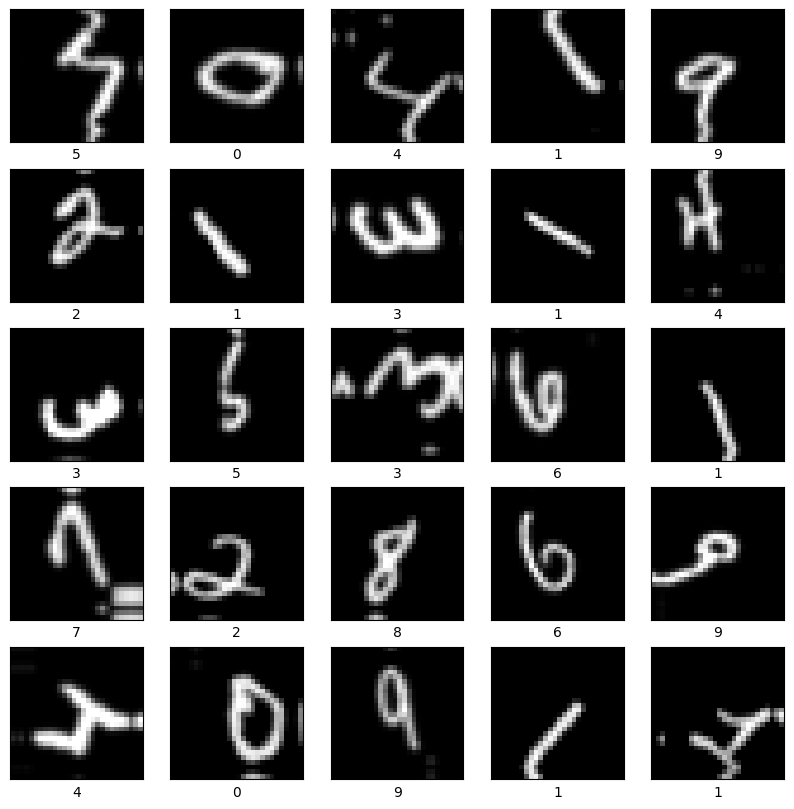

In [20]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.xlabel(y_train[i])
plt.show()

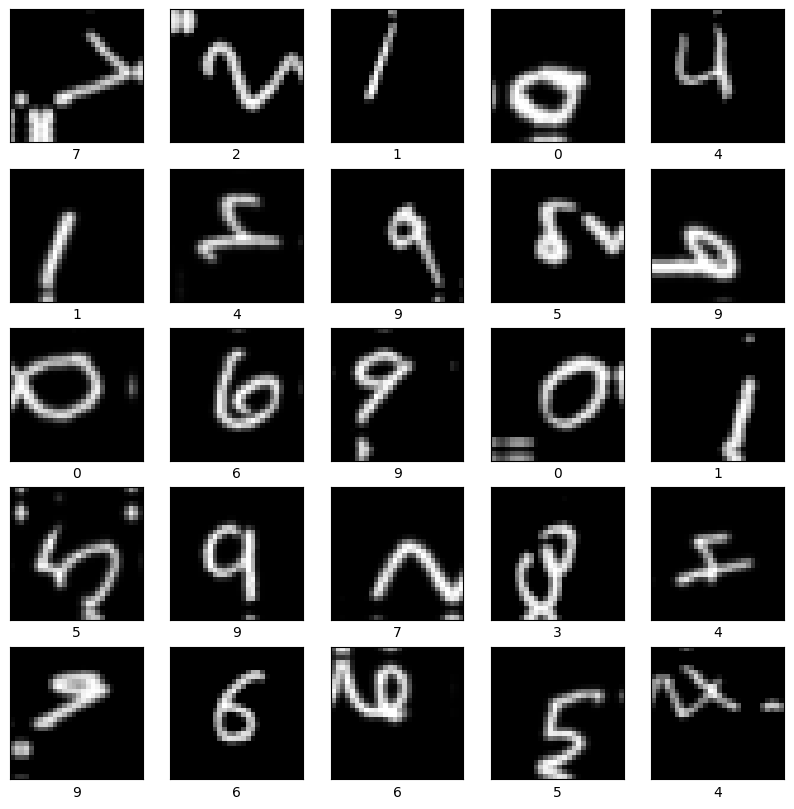

In [21]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.gray)
    plt.xlabel(y_test[i])
plt.show()

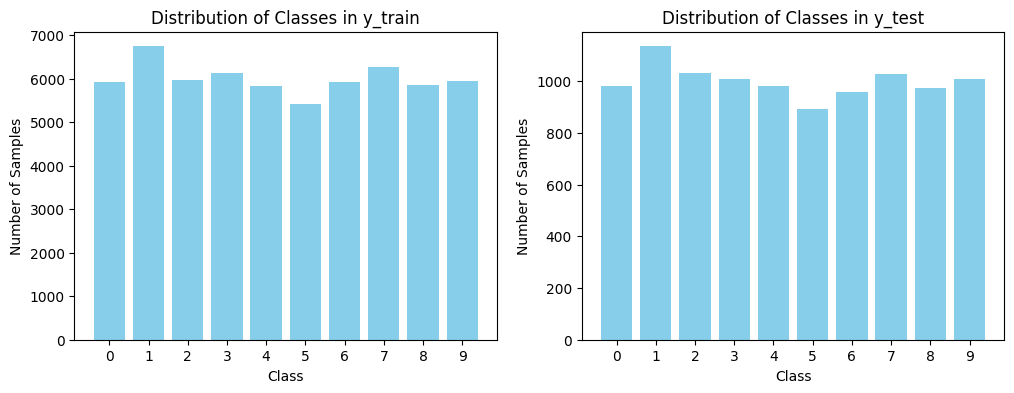

In [22]:
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(unique_classes_train, counts_train, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_train')
plt.xticks(unique_classes_train)

plt.subplot(1, 2, 2)
plt.bar(unique_classes_test, counts_test, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_test')
plt.xticks(unique_classes_test)
plt.show()

## 3 - CNN Modele

### Parameters

In [23]:
outer_k_folds = 4
inner_k_folds = 3
epochs_cnn = 10
monitor_callback_cnn = "val_accuracy"
patience_callback_cnn = 3

### Modele

In [24]:
# Function to create CNN model
def create_cnn_model(dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer=RMSprop(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [25]:
# Define the parameter grid for inner CV
param_grid = {
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.0001, 0.001],
    'batch_size': [64, 128]
}

In [ ]:
# Outer CV loop
outer_cv = StratifiedKFold(n_splits=outer_k_folds, shuffle=True)
outer_results = []
best_models = []

for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X_train_cnn, y_train)):
    print(f"\n=== Outer Fold {outer_fold + 1}/{outer_k_folds} ===")

    X_outer_train, X_outer_test = X_train_cnn[outer_train_idx], X_train_cnn[outer_test_idx]
    y_outer_train, y_outer_test = y_train[outer_train_idx], y_train[outer_test_idx]

    # Inner CV loop for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=inner_k_folds, shuffle=True)
    best_inner_score = -np.inf
    best_params = None
    best_model = None

    for params in ParameterGrid(param_grid):
        print(f"\nTesting parameters: {params}")
        inner_scores = []

        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_outer_train, y_outer_train)):
            print(f"-- Inner fold: {inner_fold+1}/{inner_k_folds}  --")
            X_inner_train, X_inner_val = X_outer_train[inner_train_idx], X_outer_train[inner_val_idx]
            y_inner_train, y_inner_val = y_outer_train[inner_train_idx], y_outer_train[inner_val_idx]

            model = create_cnn_model(dropout_rate=params['dropout_rate'], learning_rate=params['learning_rate'])

            history = model.fit(
                X_inner_train, y_inner_train,
                epochs=epochs_cnn,
                batch_size=params['batch_size'],
                validation_data=(X_inner_val, y_inner_val),
                callbacks=[EarlyStopping(monitor=monitor_callback_cnn, patience=patience_callback_cnn, mode='max', restore_best_weights=True)],
                verbose=1
            )

            _, val_accuracy = model.evaluate(X_inner_val, y_inner_val, verbose=0, batch_size=params['batch_size'])
            inner_scores.append(val_accuracy)

        mean_inner_score = np.mean(inner_scores)
        print(f"Mean validation accuracy for {params}: {mean_inner_score:.4f}")

        if mean_inner_score > best_inner_score:
            best_inner_score = mean_inner_score
            best_params = params
            best_model = model

    print(f"Best parameters for outer fold {outer_fold + 1}: {best_params}")
    print(f"Best inner validation accuracy: {best_inner_score:.4f}")

    # Re-train the best model on the entire outer training set with the best parameters
    best_model = create_cnn_model(dropout_rate=best_params['dropout_rate'], learning_rate=best_params['learning_rate'])
    best_model.fit(
        X_outer_train, y_outer_train,
        epochs=epochs_cnn,
        batch_size=best_params['batch_size'],  # Use the best batch_size
        callbacks=[EarlyStopping(monitor=monitor_callback_cnn, patience=patience_callback_cnn, mode='max', restore_best_weights=True)],
        verbose=0
    )

    # Evaluate on the outer test set
    _, outer_test_accuracy = best_model.evaluate(X_outer_test, y_outer_test, verbose=0, batch_size=best_params['batch_size'])
    print(f"Outer Fold {outer_fold + 1} - Test Accuracy: {outer_test_accuracy:.4f}")
    outer_results.append(outer_test_accuracy)
    best_models.append(best_model)


=== Outer Fold 1/4 ===

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001}
-- Inner fold: 1 --


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 106ms/step - accuracy: 0.1949 - loss: 2.4049 - val_accuracy: 0.1580 - val_loss: 2.7681
Epoch 2/10
416/469 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.3860 - loss: 1.7335

In [ ]:
#  Print outer CV results
print("\n--- Nested Cross-Validation Results ---")
for i, accuracy in enumerate(outer_results):
    print(f"Outer Fold {i + 1}: Test accuracy = {accuracy:.4f}")

mean_accuracy = np.mean(outer_results)
std_accuracy = np.std(outer_results)
print(f"\nMean Test Accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")

In [ ]:
# Evaluate the best models on the test set
test_accuracies = []
for i, model in enumerate(best_models):
    _, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
    test_accuracies.append(test_accuracy)
    print(f"Model from outer fold {i + 1} - Test Accuracy: {test_accuracy:.4f}")

mean_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)
print(f"\nMean Test Accuracy on holdout set: {mean_test_accuracy:.4f} (±{std_test_accuracy:.4f})")

In [ ]:
# Select the best model based on outer CV performance
best_model_idx = np.argmax(outer_results)
best_model = best_models[best_model_idx]
print(f"\nBest model is from outer fold {best_model_idx + 1}")

In [ ]:
# Evaluate the best model on the test set
best_test_loss, best_test_accuracy = best_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Best Model Test Accuracy: {best_test_accuracy:.4f}")

### Results

#### For the best fold

In [ ]:
# Plot training history for the best model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_model.history.history['accuracy'], label='Train')
plt.plot(best_model.history.history['val_accuracy'], label='Validation')
plt.title('Best Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(best_model.history.history['loss'], label='Train')
plt.plot(best_model.history.history['val_loss'], label='Validation')
plt.title('Best Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Predict classes using the best model
y_pred = best_model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Best Model)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    accuracy = (tn + tp) / (tp + fn + tn + fp)
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-score: {f1:.4f}\n')

In [ ]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (Best Model)')
plt.legend(loc="lower right")
plt.show()